In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn import random_projection
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Dimensionality reduction
We'll work with the PBMC scRNA dataset we've previously seen in our lecture of differential expression. As mentioned last lecture, this dataset is used in a number of different tutorials, including for the [scanpy package](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [2]:
pbmc = pd.read_csv('pbmc3k.csv.gz',index_col=0)

In [ ]:
pbmc = (pbmc.T/pbmc.sum(1)).T*1000000 # TPM
pbmc = np.log((pbmc.T/pbmc.sum(1)).T*1000000 + 1) # log(TPM+1)
pbmc

,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2.1,AL590523.1,CT476828.1,PNRC2.1,SRSF10.1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGCATGAGAGGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before anything, let's filter for genes that are expressed in a reasonable number of cells

In [ ]:
genes_to_keep = (pbmc > 0).sum() > 25 # Keep genes that have at least 25 non-zero values
pbmc_filtered = pbmc[genes_to_keep.index[genes_to_keep]] # Filtered dataset
pbmc_filtered

,NOC2L,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,PUSL1,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1,PNRC2.1,SRSF10.1
AAACATACAACCAC-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.633497,6.025993,0.000000,8.326402,6.025993,0.0,7.410474,0.000000,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.000000,6.013504,0.0,0.000000,0.000000,0.0,0.0,0.0,...,8.026285,6.013504,0.000000,8.814564,5.322799,0.0,7.397962,5.322799,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,5.763814,0.000000,0.0,5.763814,0.000000,0.0,0.0,0.0,...,7.147752,0.000000,0.000000,6.860332,6.455391,0.0,7.147752,0.000000,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,8.134873,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.324309,0.000000,5.939991,7.036847,6.631821,0.0,6.631821,0.000000,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,6.927919,0.000000,0.000000,0.000000,7.620576,0.0,6.927919,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,0.0,8.305502,0.000000,0.0,0.000000,5.669653,0.0,0.0,0.0,...,7.746072,5.669653,0.000000,5.669653,0.000000,0.0,5.669653,0.000000,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,5.673692,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.616653,0.000000,5.673692,6.365120,5.673692,0.0,7.057407,0.000000,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,8.332734,0.000000,0.000000,8.332734,0.000000,0.0,7.773299,0.000000,0.0,0.0
TTTGCATGAGAGGC-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.577698,0.000000,6.885062,0.000000,0.000000,0.0,6.885062,0.000000,0.0,0.0


## Linear dimensionality reduction approaches: PCA, PLS, and random projections.
We'll mean center the data in each case.
### PCA
Let's compute PCs and keep enough dimensions to capture 90% of variance in the data (this is pretty arbitrary)

In [5]:
pbmc_filtered_centered = pbmc_filtered.apply(lambda x: x-x.mean())
U,s,Vt = np.linalg.svd(pbmc_filtered_centered)

In [6]:
PVE = s**2/(s**2).sum()
num_pcs = np.where(PVE.cumsum() > 0.9)[0][0]
num_pcs

np.int64(1749)

In [7]:
X_PCA = U[:,:num_pcs].dot(np.diag(s[:num_pcs]))
X_PCA.shape

(2700, 1749)

### PLS
PLS is a supervised decomposition, so we need to define a target with which our decomposition should be aligned. We'll base our choice on the following result from the scanpy tutorial: ![cell type parker genes](data/pbmc3k_104_0.png)

CST3 seems to be reasonably highly expressed in a few myeloid cell types (monocytes, dendritic cells, megakaryocytes) and not so highly expressed in lymphoid cells (T cells, B cells, and NK cells), while IL17R, CD79A, and GNLY are reasonably expressed in those remaining cell types. We'll use expression of these four genes as the target and find directions in the remainder of the data that covary with these.

In [ ]:
target_genes = ['CST3','IL17RA','CD79A','GNLY']
y = pbmc_filtered_centered[target_genes] # Target genes (response matrix)
x = pbmc_filtered_centered.drop(columns=target_genes) # Other genes (predictor matrix)
pls = PLSRegression(n_components=20) # 20 components for PLS regression
pls.fit(x,y)
pls.score(x,y)

0.9898190896309614

In [ ]:
X_PLS = pls.x_scores_ # Scores for the predictor matrix (x) in the PLS model 
X_PLS.shape # 20 components 

(2700, 20)

### Random projections
Finally we'll use a data independent method with random projections. Internally sklearn is going to use the JL-lemma to determine the number of dimensions.

In [10]:
transformer = random_projection.GaussianRandomProjection(eps=.75)
X_random = transformer.fit_transform(pbmc_filtered_centered)
X_random.shape

(2700, 224)

## Distortion
So now we've got our three lower-dimensional representations of the data. To evaluate them, let's first compare how much each method distorted distances from the high-dimensional space.

In [11]:
dist_high = distance.pdist(pbmc_filtered,'euclidean')
dist_pca = distance.pdist(X_PCA,'euclidean')
dist_pls = distance.pdist(X_PLS,'euclidean')
dist_random = distance.pdist(X_random,'euclidean')

In [12]:
distance_correlations = 1 - distance.squareform(distance.pdist([dist_high, dist_pca, dist_pls, dist_random],'correlation'))
labels = ['high dimension', 'PCA', 'PLS', 'Random']
distance_correlations = pd.DataFrame(distance_correlations, columns=labels, index=labels)
distance_correlations

,high dimension,PCA,PLS,Random
high dimension,1.000000,0.998169,0.661503,0.806281
PCA,0.998169,1.000000,0.625994,0.804130
PLS,0.661503,0.625994,1.000000,0.535319
Random,0.806281,0.804130,0.535319,1.000000


## Clustering
Next we'll evaluate differences in clustering

In [13]:
clust_high = KMeans(n_clusters=8).fit(pbmc_filtered).labels_
clust_pca = KMeans(n_clusters=8).fit(X_PCA).labels_
clust_pls = KMeans(n_clusters=8).fit(X_PLS).labels_
clust_random = KMeans(n_clusters=8).fit(X_random).labels_

In [14]:
MI = np.eye(4)
MI[0,1] = adjusted_mutual_info_score(clust_high,clust_pca)
MI[0,2] = adjusted_mutual_info_score(clust_high,clust_pls)
MI[0,3] = adjusted_mutual_info_score(clust_high,clust_random)
MI[1,2] = adjusted_mutual_info_score(clust_pca,clust_pls)
MI[1,3] = adjusted_mutual_info_score(clust_pca,clust_random)
MI[2,3] = adjusted_mutual_info_score(clust_pls,clust_random)
MI = pd.DataFrame(MI, columns=labels, index=labels)
MI

,high dimension,PCA,PLS,Random
high dimension,1.0,0.617568,0.604710,0.521066
PCA,0.0,1.000000,0.626626,0.479490
PLS,0.0,0.000000,1.000000,0.556598
Random,0.0,0.000000,0.000000,1.000000


### Loadings
Finally, for PCA and PLS we can compare the loadings

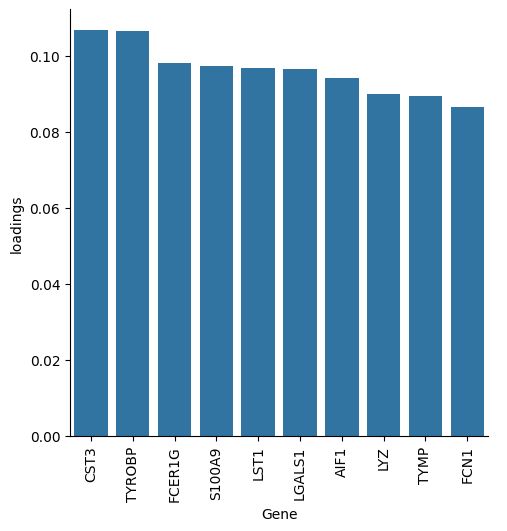

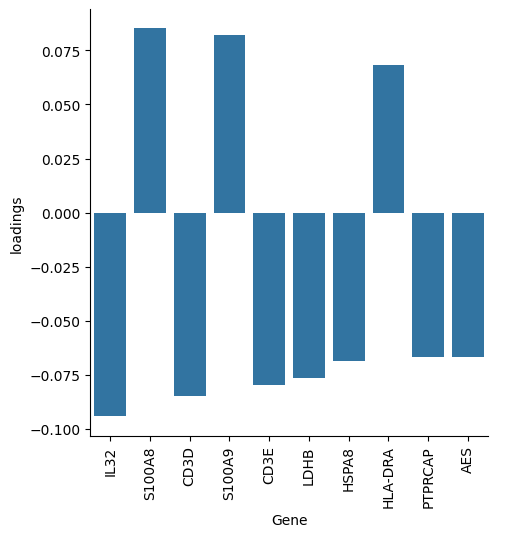

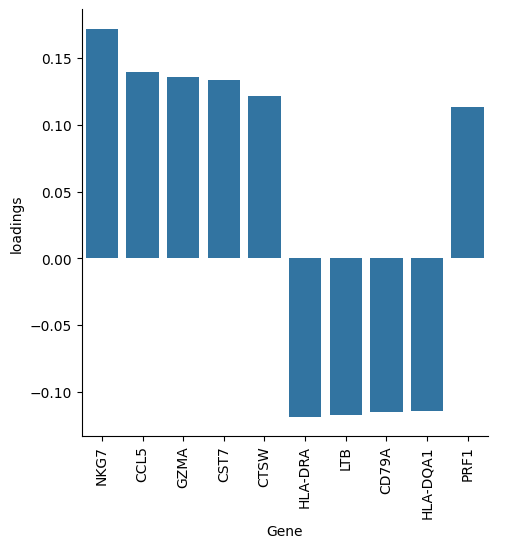

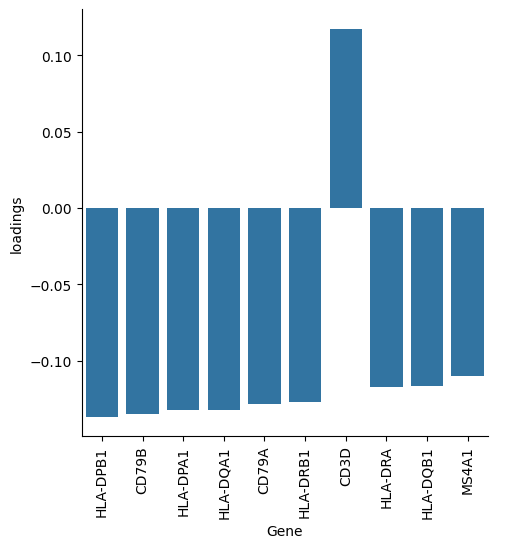

In [15]:
for i in range(4):
    column_df = pd.DataFrame()
    idx_sort = np.argsort(-abs(Vt[i]))[:10]
    column_df['loadings'] = Vt[i,idx_sort]
    column_df['Gene'] = pbmc_filtered.columns[idx_sort]
    ax = sns.catplot(column_df, x='Gene', y='loadings', kind='bar')
    ax.tick_params(axis='x', rotation=90)

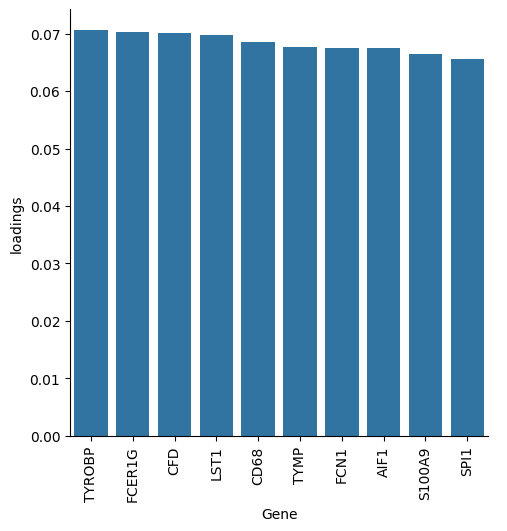

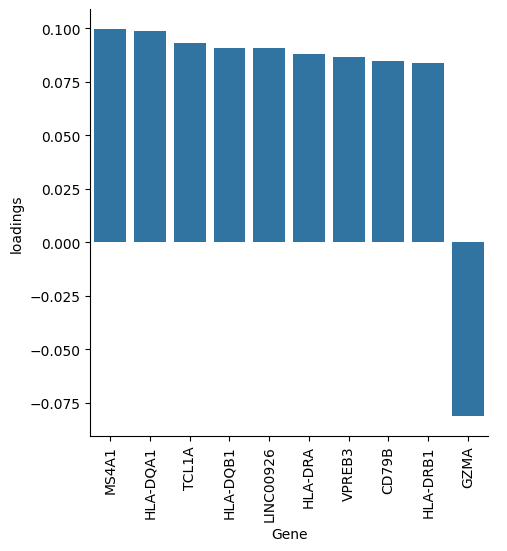

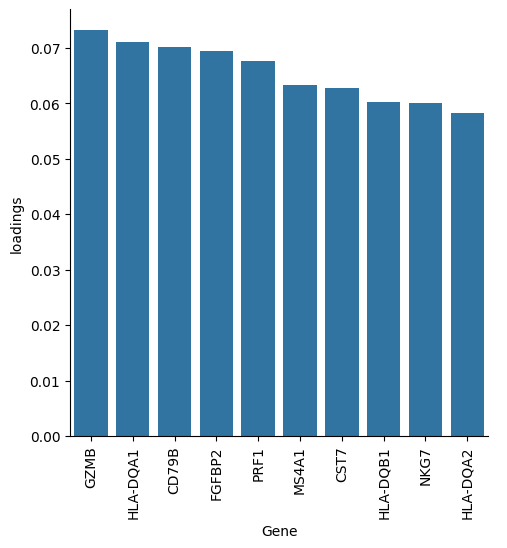

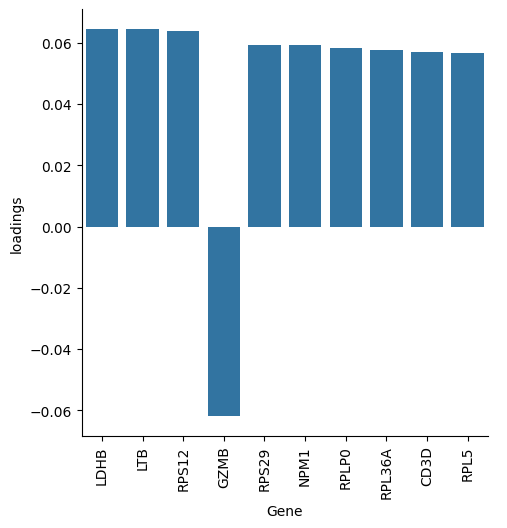

In [16]:
loadings = pls.x_loadings_.T
for i in range(4):
    column_df = pd.DataFrame()
    idx_sort = np.argsort(-abs(loadings[i]))[:10]
    column_df['loadings'] = loadings[i,idx_sort]
    column_df['Gene'] = pbmc_filtered.drop(columns=target_genes).columns[idx_sort]
    ax = sns.catplot(column_df, x='Gene', y='loadings', kind='bar')
    ax.tick_params(axis='x', rotation=90)

<Axes: >

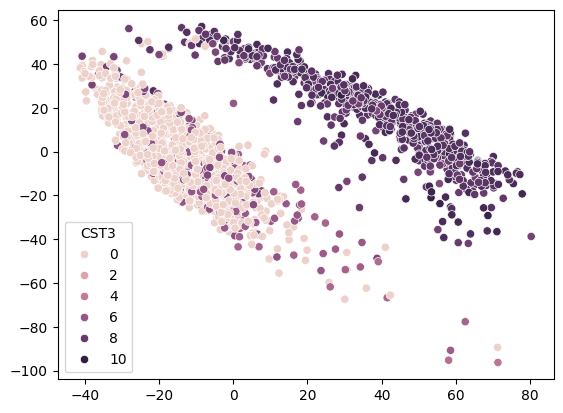

In [17]:
sns.scatterplot(x=X_PCA[:,0], y=X_PCA[:,1], hue=pbmc_filtered['CST3'])
#sns.scatterplot(x=X_PCA[:,0], y=X_PCA[:,1], hue=(pbmc_filtered['CST3'] > 0))

<Axes: >

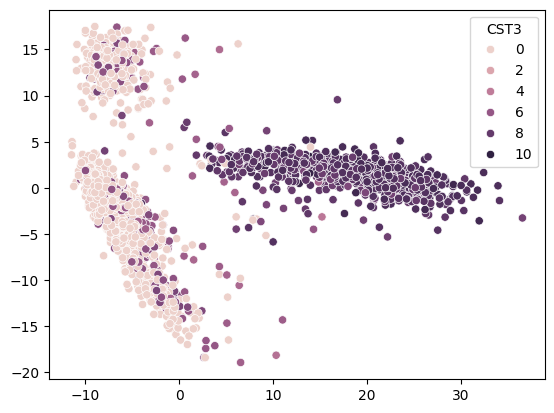

In [18]:
sns.scatterplot(x=X_PLS[:,0], y=X_PLS[:,1], hue=pbmc_filtered['CST3'])
#sns.scatterplot(x=X_PLS[:,0], y=X_PLS[:,1], hue=(pbmc_filtered['CST3'] > 0))

<Axes: >

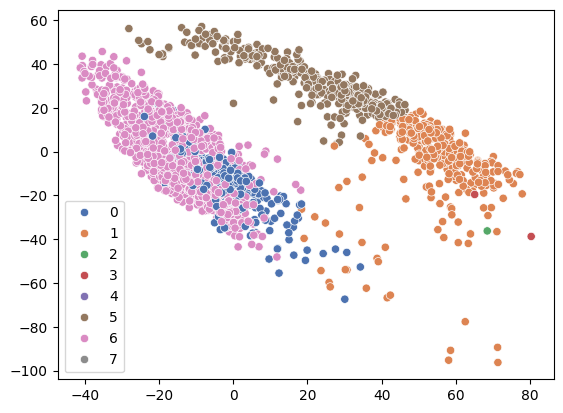

In [19]:
sns.scatterplot(x=X_PCA[:,0], y=X_PCA[:,1], hue=clust_pca,palette='deep')

<Axes: >

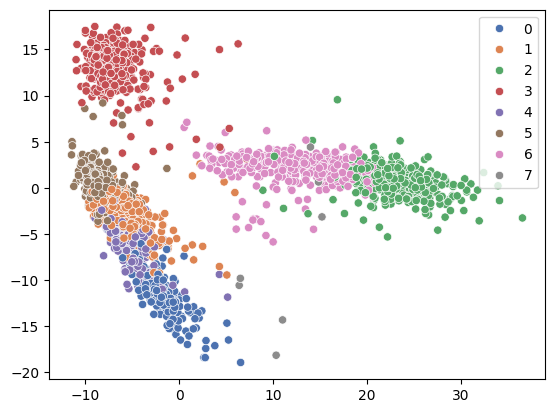

In [20]:
sns.scatterplot(x=X_PLS[:,0], y=X_PLS[:,1], hue=clust_pls,palette='deep')